## Data Exploration

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
# Load data from json file
import json
from pprint import pprint

with open('eth-donation-requests.json') as f:
    data = json.load(f)

In [3]:
#Convert the dictionary into dataframe
import pandas as pd

new = pd.DataFrame(data)
new.head(10)

,tagged_begging
0,2018-01-01 20:13:18
1,2018-01-01 20:16:10
2,2018-01-01 20:16:37
3,2018-01-01 20:16:36
4,2018-01-01 20:26:21
5,2018-01-01 20:21:41
6,2018-01-01 20:12:16
7,2018-01-01 20:35:47
8,2018-01-01 20:35:38
9,2018-01-01 20:47:52


In [4]:
type(new['tagged_begging'])

pandas.core.series.Series

In [5]:
#Convert the column to Datetime format and sort in ascending order

df = pd.to_datetime(new.stack()).unstack().sort_values(by = 'tagged_begging')
df.head(10)

,tagged_begging
6,2018-01-01 20:12:16
0,2018-01-01 20:13:18
1,2018-01-01 20:16:10
3,2018-01-01 20:16:36
2,2018-01-01 20:16:37
5,2018-01-01 20:21:41
10,2018-01-01 20:26:05
4,2018-01-01 20:26:21
11,2018-01-01 20:31:03
12,2018-01-01 20:34:46


In [6]:
#Set the timestamp as index 

df.set_index('tagged_begging', inplace=True)

In [7]:
#Assign count to each activity 
df['Count']=1

#### Resampling the data as per the required frequency

In [8]:
#Resample the data as per 15 min interval

DF= df.resample('15T').sum()
DF.head(10)

,Count
tagged_begging,
2018-01-01 20:00:00,2
2018-01-01 20:15:00,6
2018-01-01 20:30:00,9
2018-01-01 20:45:00,7
2018-01-01 21:00:00,1
2018-01-01 21:15:00,4
2018-01-01 21:30:00,0
2018-01-01 21:45:00,4
2018-01-01 22:00:00,9


In [9]:
from pandas import ExcelWriter

writer = ExcelWriter('Donation_req_activity.xlsx')
DF.to_excel(writer,'Sheet1')
writer.save()

### Observed Data

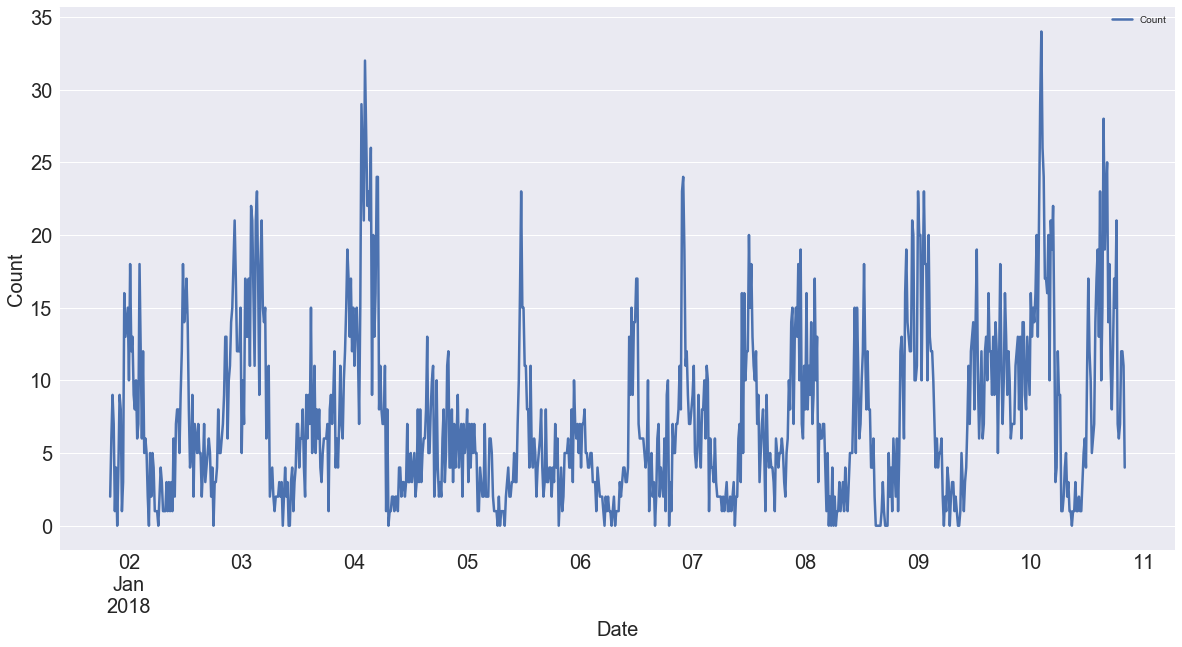

In [10]:
DF['2018-01-01 20:00:00': '2018-01-10 20:00:00'].plot(figsize=(20,10), linewidth=2.5, fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Count', fontsize=20);

### Rolling Mean for past 24 hrs

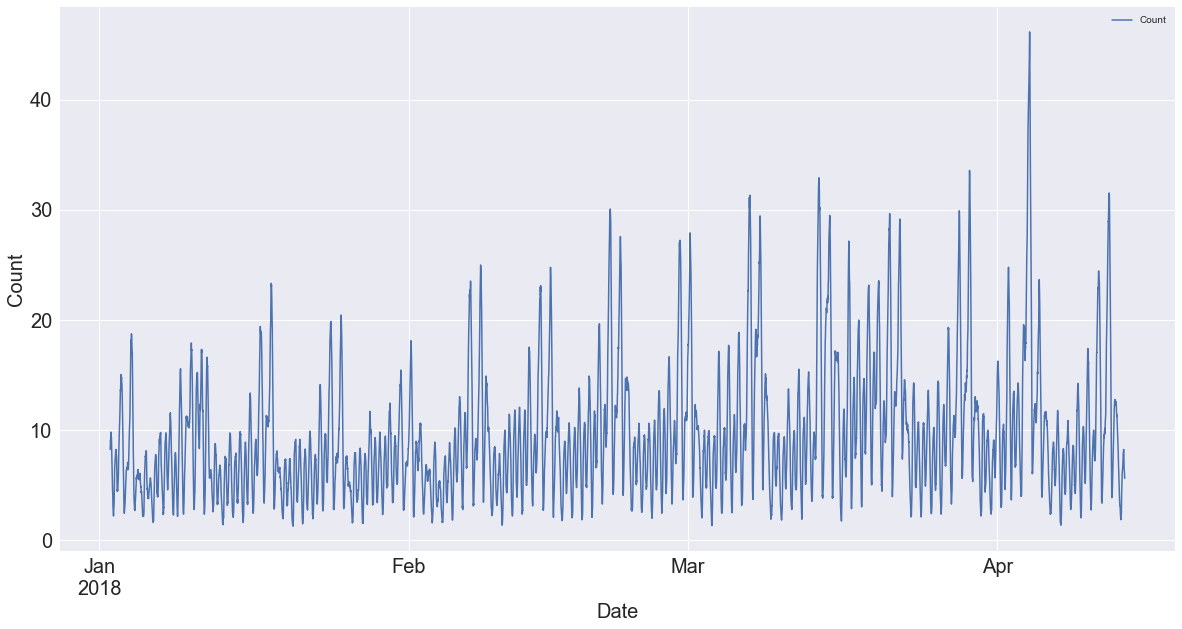

In [11]:
DF[['Count']].rolling(24).mean().plot(figsize=(20,10), linewidth=1.5, fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Count', fontsize=20);

### Difference plot

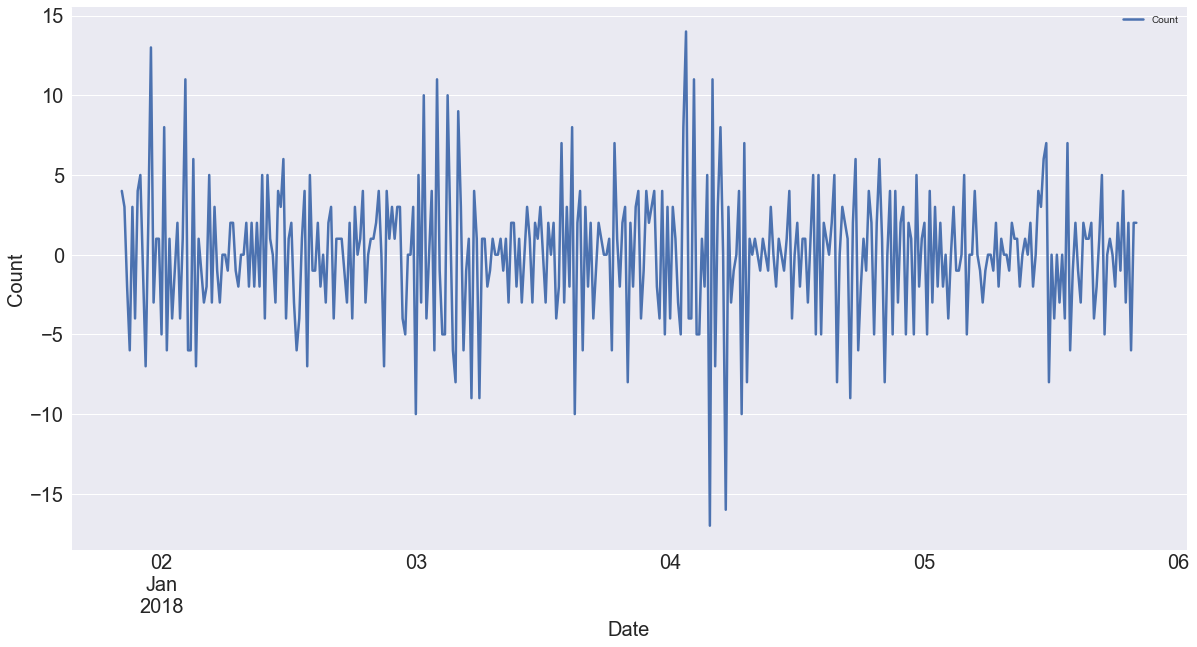

In [12]:
DF['2018-01-01 20:00:00': '2018-01-05 20:00:00'].diff().plot(figsize=(20,10), linewidth=2.5, fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Count', fontsize=20);

### Outliers Detection

In [13]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [14]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

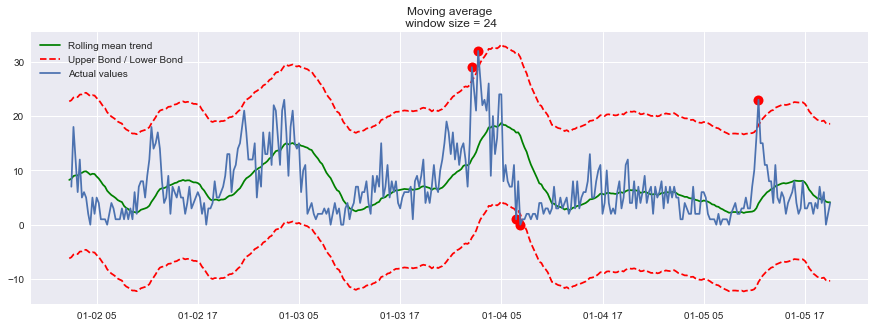

In [15]:
plotMovingAverage(DF['2018-01-01 20:00:00': '2018-01-05 20:00:00'], 24, plot_intervals=True, plot_anomalies=True) 

In [16]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 2018-01-01 20:00:00 to 2018-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
Count    9788 non-null int64
dtypes: int64(1)
memory usage: 472.9 KB


## Time Series Forecasting 

#### ARIMA stands for AutoRegressive Integrated Moving Average, and it's a common method to model time series data where there is dependence among temporal values. SARIMA is a similar method that adds seasonality element to ARIMA. As shown below, user needs to specify some parameters to fit an ARIMA model within the Python statsmodel package (version 0.8). The ARIMA parameters are (p,d,q):
p - the auto-regression term that comprises p number of past values to predict present value. For example, if p=2, then past values y(t-1), y(t-2) would be used to predict y(t).

d - the integrated part of the model. Generally d=1, corresponding to the difference between current value and previous one. If d >1, it means the differencing would be performed more than once (i.e., difference of prior d number of values and present value).

q - the Moving Average terms, which is used to generate the error terms of the model. This results in a linear combination of errors for the prior q data point, where each error is defined as the difference between the moving average value and the actual value at a given time point (t).

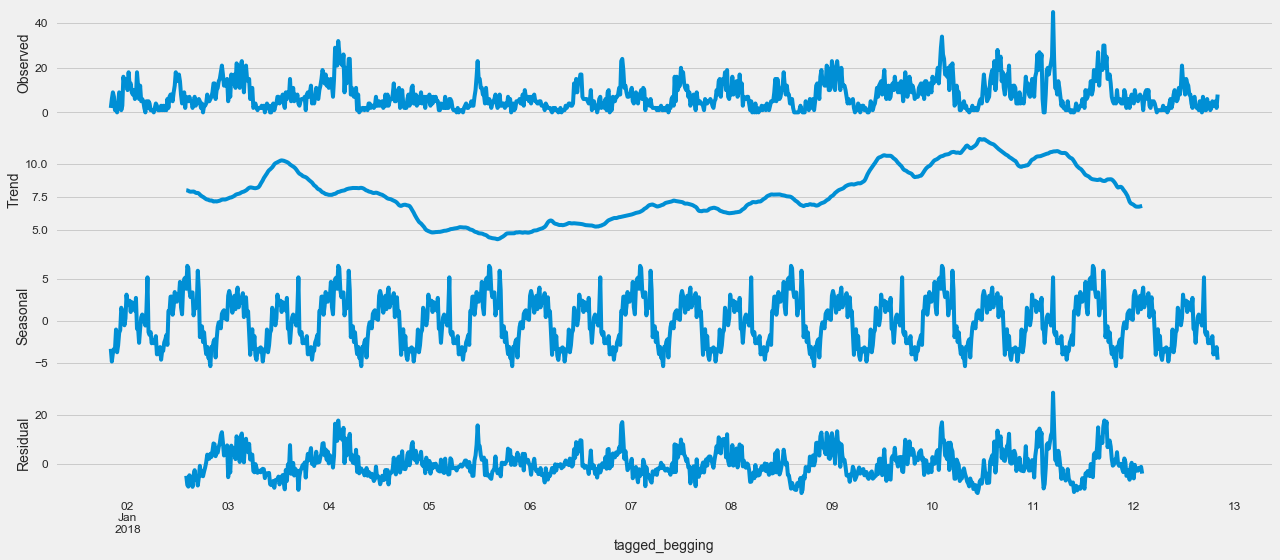

In [17]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Decomposition to find trend, seasonality and residual in the data
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decompfreq = 6*24
decomposition = sm.tsa.seasonal_decompose(DF['2018-01-01 20:00:00': '2018-01-12 20:00:00'], model='additive', freq = decompfreq)
fig = decomposition.plot()
plt.show()

### Autocorrelation Plot

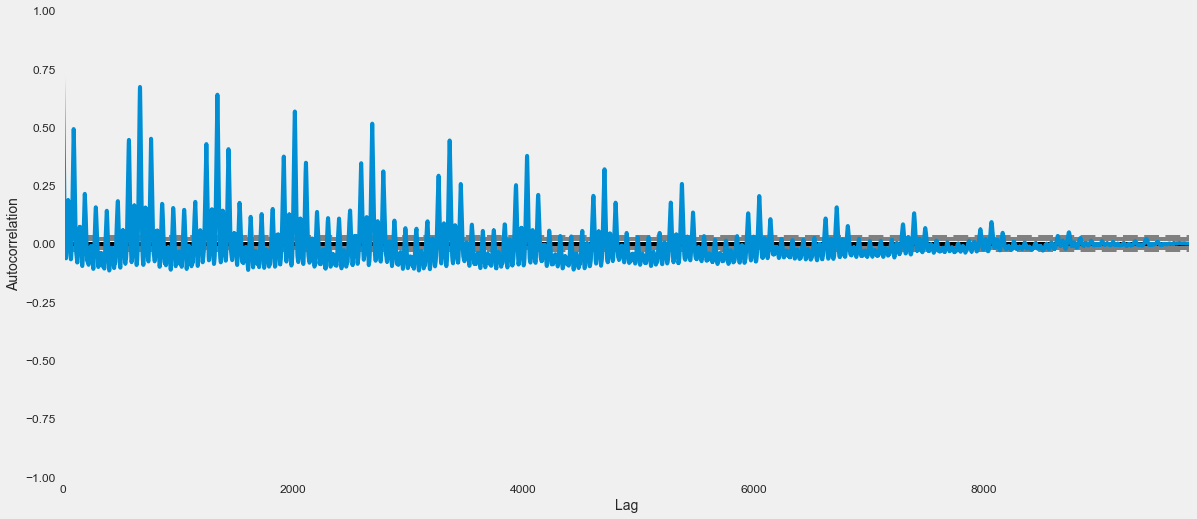

In [18]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(DF)
plt.show()

Zooming in the above plot for the time interval 1st Jan, 8pm - 10th Jan, 8pm.

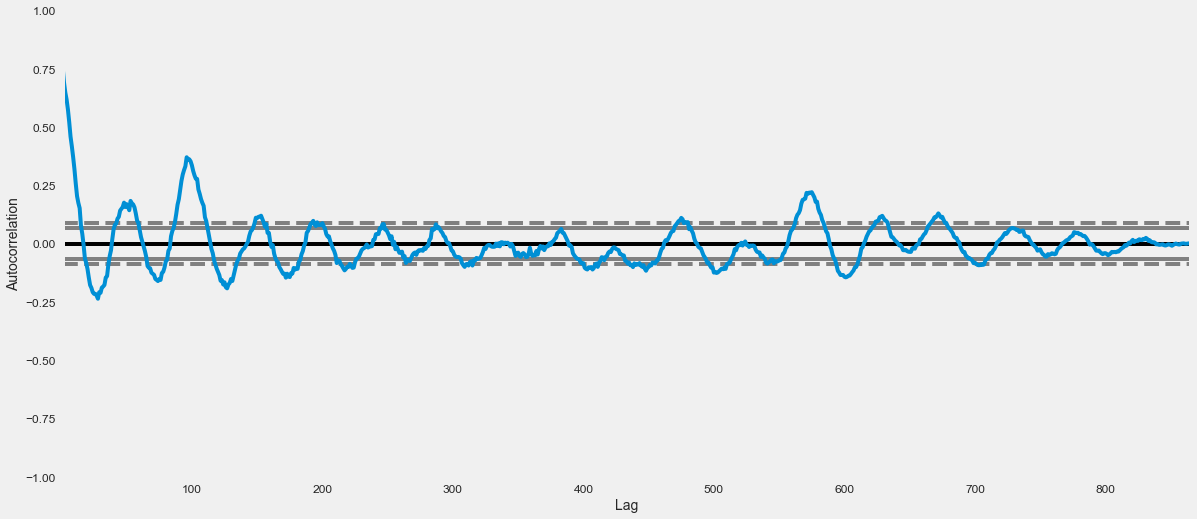

In [19]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(DF['2018-01-01 20:00:00': '2018-01-10 20:00:00'])
plt.show()

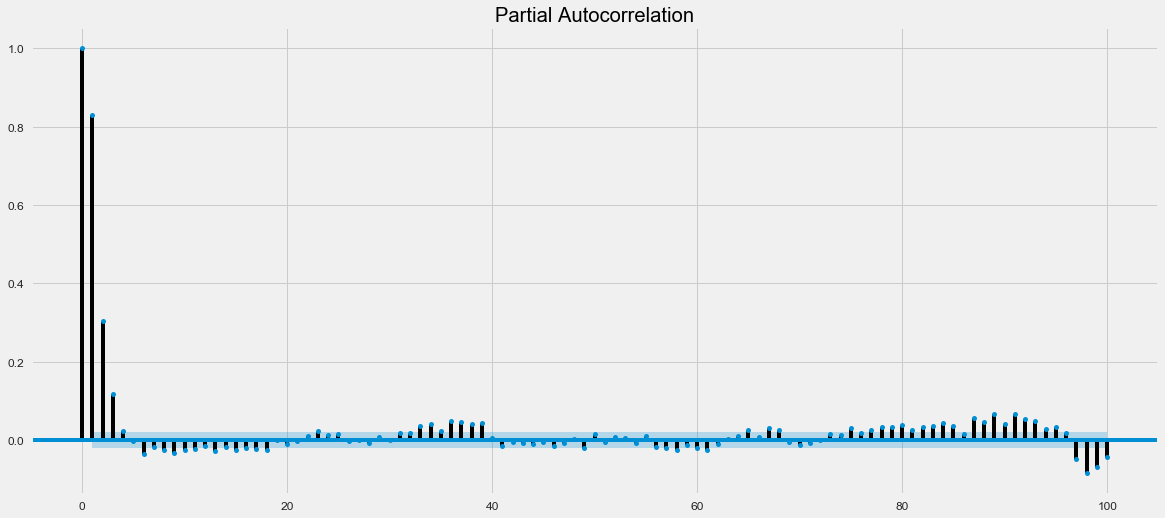

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(DF, lags=100)
plt.show()

### Parameter Selection:

Use a “grid search” to find the optimal set of parameters that yields the best performance for the model.

In [21]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 0, 24)
SARIMAX: (0, 1, 0) x (0, 1, 1, 24)
SARIMAX: (0, 1, 0) x (1, 0, 0, 24)


In [22]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(DF,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 24)12 - AIC:77442.81562037495
ARIMA(0, 0, 0)x(0, 0, 1, 24)12 - AIC:75596.41371522432
ARIMA(0, 0, 0)x(0, 1, 0, 24)12 - AIC:76201.1093804974
ARIMA(0, 0, 0)x(0, 1, 1, 24)12 - AIC:68659.93120500074
ARIMA(0, 0, 0)x(1, 0, 0, 24)12 - AIC:73728.00443945223
ARIMA(0, 0, 0)x(1, 0, 1, 24)12 - AIC:68785.08803153192
ARIMA(0, 0, 0)x(1, 1, 0, 24)12 - AIC:71563.46551463149
ARIMA(0, 0, 0)x(1, 1, 1, 24)12 - AIC:68589.89858261951
ARIMA(0, 0, 1)x(0, 0, 0, 24)12 - AIC:69594.53041485176
ARIMA(0, 0, 1)x(0, 0, 1, 24)12 - AIC:68420.22789295852
ARIMA(0, 0, 1)x(0, 1, 0, 24)12 - AIC:70597.43652820369
ARIMA(0, 0, 1)x(0, 1, 1, 24)12 - AIC:63256.92684256581
ARIMA(0, 0, 1)x(1, 0, 0, 24)12 - AIC:67474.80387487587
ARIMA(0, 0, 1)x(1, 0, 1, 24)12 - AIC:63380.51919412
ARIMA(0, 0, 1)x(1, 1, 0, 24)12 - AIC:66412.68337345574
ARIMA(0, 0, 1)x(1, 1, 1, 24)12 - AIC:63223.28261394132
ARIMA(0, 1, 0)x(0, 0, 0, 24)12 - AIC:58662.891103138776
ARIMA(0, 1, 0)x(0, 0, 1, 24)12 - AIC:58516.95907469598
ARIMA(0, 1, 0

C:\Users\dhamane\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 24)12 - AIC:56585.82322881274
ARIMA(1, 0, 1)x(1, 1, 0, 24)12 - AIC:60263.25451777025
ARIMA(1, 0, 1)x(1, 1, 1, 24)12 - AIC:56447.93564909483
ARIMA(1, 1, 0)x(0, 0, 0, 24)12 - AIC:57291.52311274234
ARIMA(1, 1, 0)x(0, 0, 1, 24)12 - AIC:57145.67552296097
ARIMA(1, 1, 0)x(0, 1, 0, 24)12 - AIC:64056.629108382214
ARIMA(1, 1, 0)x(0, 1, 1, 24)12 - AIC:57019.45314787119
ARIMA(1, 1, 0)x(1, 0, 0, 24)12 - AIC:57145.51081502912
ARIMA(1, 1, 0)x(1, 0, 1, 24)12 - AIC:57062.36575930635
ARIMA(1, 1, 0)x(1, 1, 0, 24)12 - AIC:60862.122740857594
ARIMA(1, 1, 0)x(1, 1, 1, 24)12 - AIC:57019.045032524795
ARIMA(1, 1, 1)x(0, 0, 0, 24)12 - AIC:57010.520277954434
ARIMA(1, 1, 1)x(0, 0, 1, 24)12 - AIC:56864.30917683577
ARIMA(1, 1, 1)x(0, 1, 0, 24)12 - AIC:63869.54815212617
ARIMA(1, 1, 1)x(0, 1, 1, 24)12 - AIC:56721.51586655602
ARIMA(1, 1, 1)x(1, 0, 0, 24)12 - AIC:56867.894311820186
ARIMA(1, 1, 1)x(1, 0, 1, 24)12 - AIC:56675.061665519286
ARIMA(1, 1, 1)x(1, 1, 0, 24)12 - AIC:60579.893335216286
ARI

#### Conclusion: 
The output of our code suggests that SARIMAX(1, 0, 1)x(0, 1, 1, 24) yields the lowest AIC value of 56453.80318898652. We should therefore consider this to be optimal option out of all the models we have considered. 

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

### Fitting an ARIMA Time Series Model

In [23]:
mod = sm.tsa.statespace.SARIMAX(DF,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9405      0.002    387.097      0.000       0.936       0.945
ma.L1         -0.3964      0.007    -53.831      0.000      -0.411      -0.382
ma.S.L24      -1.0051      0.002   -503.315      0.000      -1.009      -1.001
sigma2        18.8939      0.177    106.448      0.000      18.546      19.242


#### Results Summary:
The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

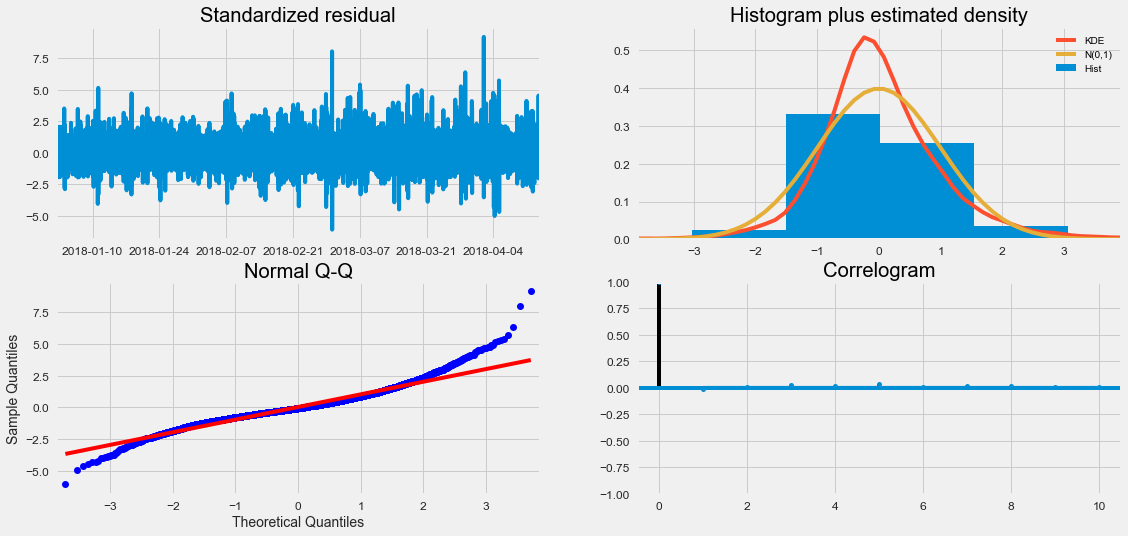

In [24]:
results.plot_diagnostics(figsize=(17, 8))
plt.show()

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

    -In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
    -The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
    -The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

### Validating Forecasts

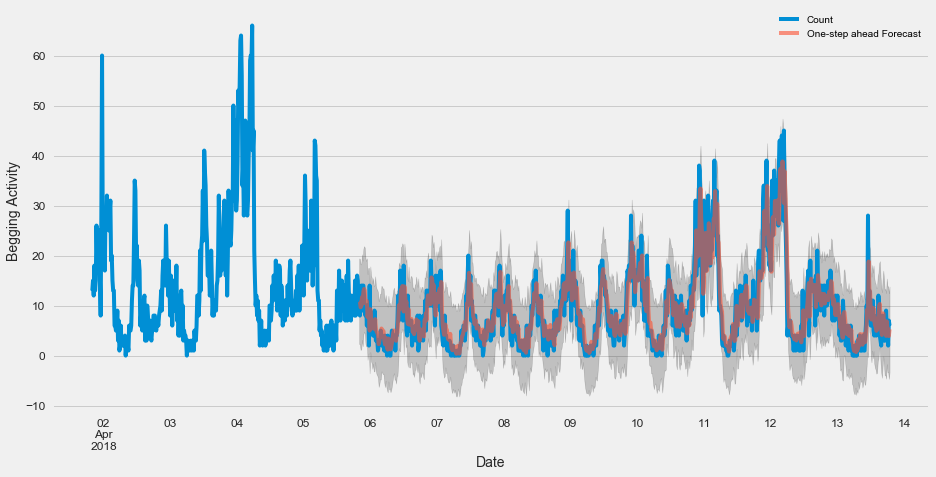

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2018-04-05 20:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = DF['2018-04-01 20:00:00':'2018-04-13 19:45:00'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.6, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Begging Activity')
plt.legend()
plt.show()

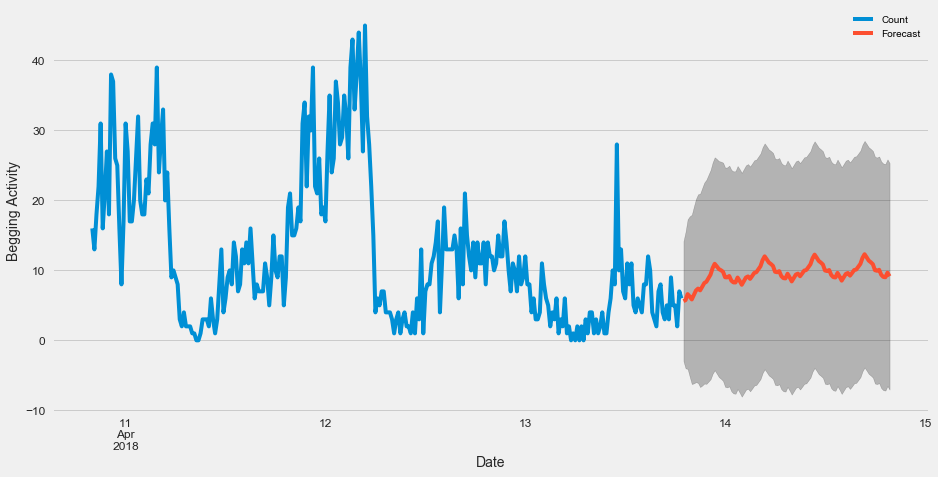

In [26]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = DF['2018-04-10 20:00:00': ].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Begging Activity')
plt.legend()
plt.show()

#### Forecast the expected future activity at the 15-minute granularity over the following hour (the 4 following time periods

Answer to Question 2

In [27]:
results.predict(start='2018-04-13 19:45:00', end= '2018-04-13 20:45:00').astype(int)

2018-04-13 19:45:00    6
2018-04-13 20:00:00    5
2018-04-13 20:15:00    6
2018-04-13 20:30:00    7
2018-04-13 20:45:00    7
Freq: 15T, dtype: int32

### Quantify the results by calculating Mean Square Error

MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

Answer to Question 3.

In [28]:
DF_forecasted = pred.predicted_mean
DF_truth = DF['2018-01-01 20:00:00':'2018-04-13 19:45:00'].Count
mse = ((DF_forecasted - DF_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))



The Mean Squared Error of our forecasts is 16.87


In [29]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 4.11


In [30]:
DF.Count.mean()

9.51593788312219

In [31]:
DF.Count.sum()

93142

In [32]:
max(DF.Count)

73

In [33]:
min(DF.Count)

0

In [34]:
np.std(DF.Count)

8.328392911785393

### Conclusion:

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point. We can use dynamic forecasts to get the results. however, one step ahead forecast is better that dynamic forecast method as it gives higher MSE value which is expected because we are relying on less historical data from the time series.

We can add more parameter range in ARIMA order (p,d,q) so that we can get more accurate model by choosing params which yield lowest AIC value. I have used (0,2) range, we can modify these parameters and accordingly improve the model.
